In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.ndimage import convolve


%matplotlib inline

In [22]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

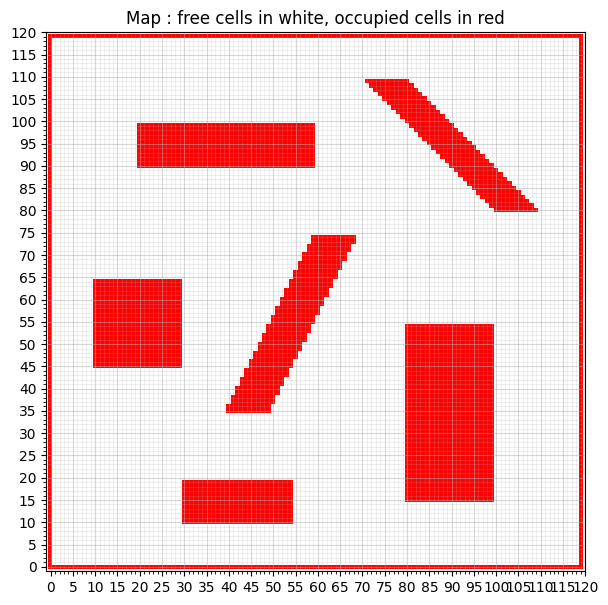

In [54]:
#Creating the grid
max_val = 120 # Size of the map

fig, ax = create_empty_plot(max_val)

r=4 #radius of the thymio (approx 7.8cm =3.9 boxes on grid)

# Creating the occupancy grid

data = np.zeros((max_val+2*r,max_val+2*r)) # Create an empty grid, with larger dimaensions than max_value to allow the convolution
for i in range(max_val): #Border
    data[r+i,r]=1
    data[r+i,max_val-1+r]=1
    data[r,i+r]=1
    data[max_val-1+r,i+r]=1

for j in range(10):        #Obstacles
    for k in range (20):
        data[40+j+k+r,35+2*k+r]=1
        data[40+j+k+r,36+2*k+r]=1

for j in range(25):
    for k in range (10):
        data[30+j+r,10+k+r]=1

for j in range(40):
    for k in range (10):
        data[20+j+r,90+k+r]=1

for j in range(20):
    for k in range (20):
        data[10+j+r,45+k+r]=1

for j in range(20):
    for k in range (40):
        data[80+j+r,15+k+r]=1

for j in range(10):        #Obstacles
    for k in range (30):
        data[100+j-k+r,80+k+r]=1


cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

# Converting the obstacles values into occupied and free cells
limit = 0 
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

occupancy_grid_r=occupancy_grid[r:r+max_val,r:r+max_val] #reduce the size of the grid to max_val

# Displaying the map
ax.imshow(occupancy_grid_r.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");


In [55]:
#Create the mask, its approximatively the circle in which the thymio can lie without tuching the border
mask=np.ones((9,9))
mask[0,0]=0
mask[0,1]=0
mask[1,0]=0
mask[0,8]=0
mask[1,8]=0
mask[0,7]=0
mask[8,0]=0
mask[8,1]=0
mask[7,0]=0
mask[8,8]=0
mask[7,8]=0
mask[8,7]=0
print(mask)

[[0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0.]]


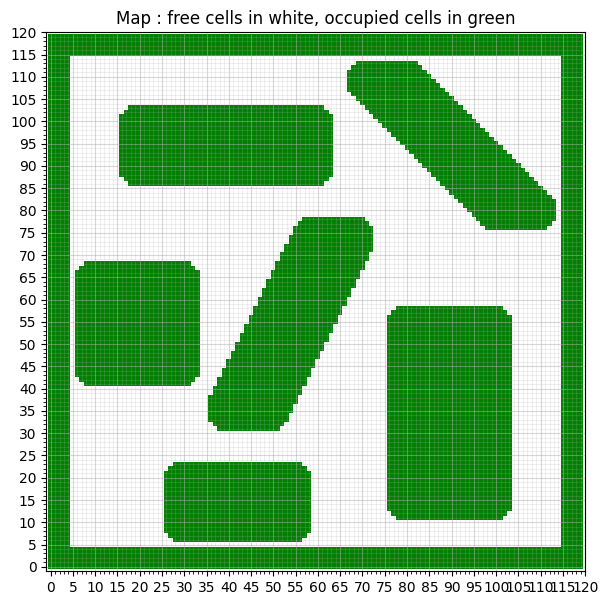

In [56]:
#Create the modified map
fig, ax = create_empty_plot(max_val)
data_mod = data.copy()
cmap_mod = colors.ListedColormap(['white', 'green'])

#Make the obstacles larger to compensate thymio size (the thymio lies in a radius of ~8cm = 4 grid boxes)
data_mod = convolve(occupancy_grid, mask) #make the convolution between the grid and the mask, 
occupancy_grid_mod=data_mod.copy()

limit = 0
occupancy_grid_mod[data_mod>limit] = 1
occupancy_grid_mod[data_mod<=limit] = 0

occupancy_grid_mod_r=occupancy_grid_mod[r:r+max_val,r:r+max_val]

# Displaying the map
ax.imshow(occupancy_grid_mod_r.transpose(), cmap=cmap_mod)
plt.title("Map : free cells in white, occupied cells in green");


In [57]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [60]:
def Key(s):
    s=tuple(s)
    Key_s=((min(gScore[s], rhs[s])) + h(s,start) + km, min(gScore[s], rhs[s]))
    #Key_s=(min(gScore[s], rhs[s])) + h(s,start) + km
    Key_s=tuple(Key_s)
    return Key_s

def h(current_node,start_node):
    current_node = np.array(current_node)
    start_node = np.array(start_node)
    return np.linalg.norm(current_node - start_node, axis=-1)
    
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.append(cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def D_Star_lite(start, goal, coords, occupancy_grid, movement_type="4N", max_val=max_val):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that no longer need to be expanded.
    global closedSet
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    global cameFrom
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    global gScore
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[goal] = 0

    global rhs
    rhs = dict(zip(coords, [np.inf for x in range(len(coords))]))
    rhs[goal] = 0

    global km
    km=0

     # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    global openSet
    openSet = dict(zip([(goal)],Key(goal)))

    current=goal

    # while there are still elements to investigate
    while openSet != {}:

        
        #the node in openSet having the lowest KeyScore[] value
        current=min(openSet,key=openSet.get)
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == start:
            return reconstruct_path(cameFrom, current), closedSet
    
        #for each neighbor of current, put them in openSet compute the rhs value of neighbor: this will help tell which node to chose next
        openSet.pop(current)
        gScore[current]=rhs[current]
        closedSet.append(current)
        
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            #if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (gScore[neighbor] == rhs[neighbor] <1000):
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_rhs = gScore[current] + deltacost

            if tentative_rhs < rhs[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                rhs[neighbor] = tentative_rhs
                
            if gScore[neighbor] != rhs[neighbor]:
                openSet[neighbor]=Key(neighbor)
        

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

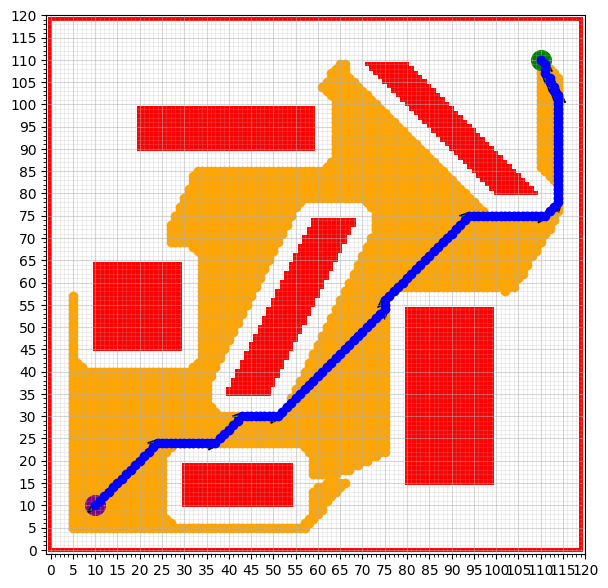

In [63]:
# Define the start and end goal
start = (110,110)
goal = (10,10)



# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])



# Run the A* algorithm
path, visitedNodes = D_Star_lite(start, goal, coords, occupancy_grid_mod_r, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(occupancy_grid_r.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
for i in range(len(path[0])-1):
    plt.arrow(path[0,i], path[1,i], path[0,i+1]-path[0,i], path[1,i+1]-path[1,i], width=0.5)